#### Kaggle tmdb-box-office-prediction competition

https://www.kaggle.com/c/tmdb-box-office-prediction

#### Import and View Data

In [111]:
import pandas as pd
import matplotlib.pyplot as plt      # matplotlib.pyplot plots data
import seaborn as sns
import re
from tqdm import tqdm
from ast import literal_eval
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.externals import joblib

In [112]:
df_modified = pd.read_csv('test.csv/test.csv')
df = df_modified
df.describe()

,id,budget,popularity,runtime
count,4398.000000,4.398000e+03,4398.000000,4394.000000
mean,5199.500000,2.264929e+07,8.550230,107.622212
std,1269.737571,3.689991e+07,12.209014,21.058290
min,3001.000000,0.000000e+00,0.000001,0.000000
25%,4100.250000,0.000000e+00,3.895186,94.000000
50%,5199.500000,7.450000e+06,7.482241,104.000000
75%,6298.750000,2.800000e+07,10.938524,118.000000
max,7398.000000,2.600000e+08,547.488298,320.000000


In [113]:
df.shape

(4398, 22)

#### Clean Data


Drop unique columns

In [114]:
df = df.drop(['imdb_id','id', 'title', 'tagline', 'poster_path', 'overview', 'original_title', 'budget'], axis=1)

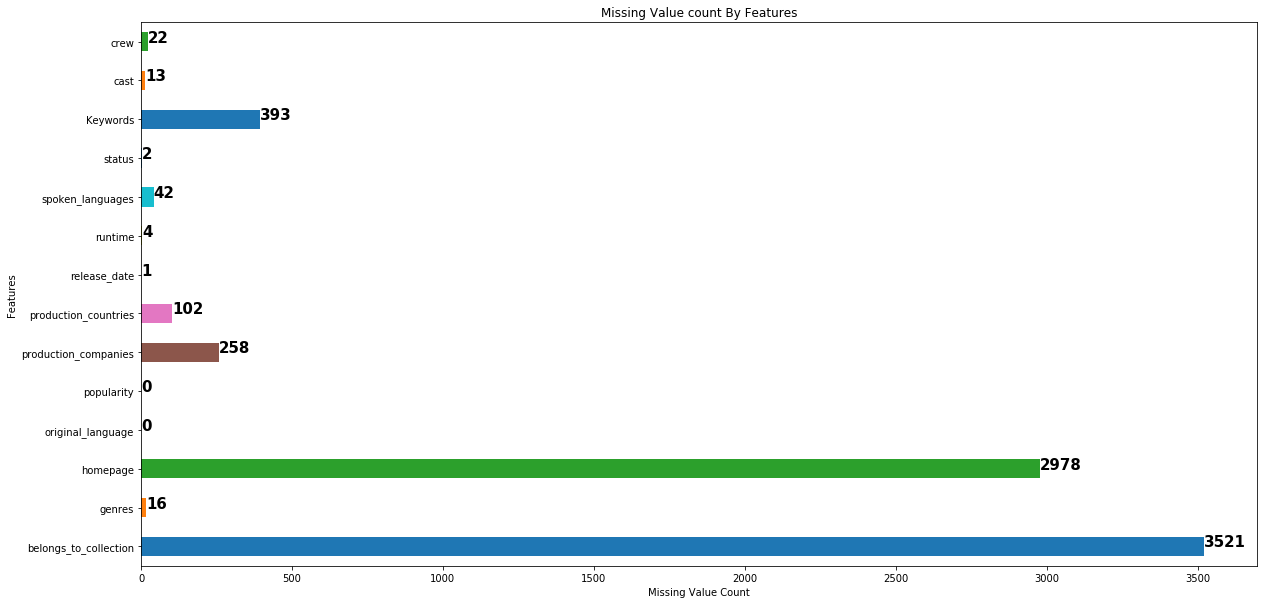

In [115]:
def NullCheckGraph(df):
    df.isna().sum().plot(kind="barh", figsize=(20,10))
    for i, v in enumerate(df.isna().sum()):
        plt.text(v, i, str(v), fontweight='bold', fontsize = 15)
    plt.xlabel("Missing Value Count")
    plt.ylabel("Features")
    plt.title("Missing Value count By Features")
    
NullCheckGraph(df)

Drop column where 70% data is null

In [116]:
df = df.drop(['belongs_to_collection', 'homepage'],axis = 1)

Drop rows with Null values

In [117]:
df = df.reset_index(drop=True)

df['status'].fillna(method='ffill', inplace=True)
df['genres'].fillna(method='ffill', inplace=True)
df['cast'].fillna(method='ffill', inplace=True)
df['crew'].fillna(method='ffill', inplace=True)
df['production_companies'].fillna(method='ffill', inplace=True)
df['production_countries'].fillna(method='ffill', inplace=True)
df['spoken_languages'].fillna(method='ffill', inplace=True)
df['release_date'].fillna(method='ffill', inplace=True)

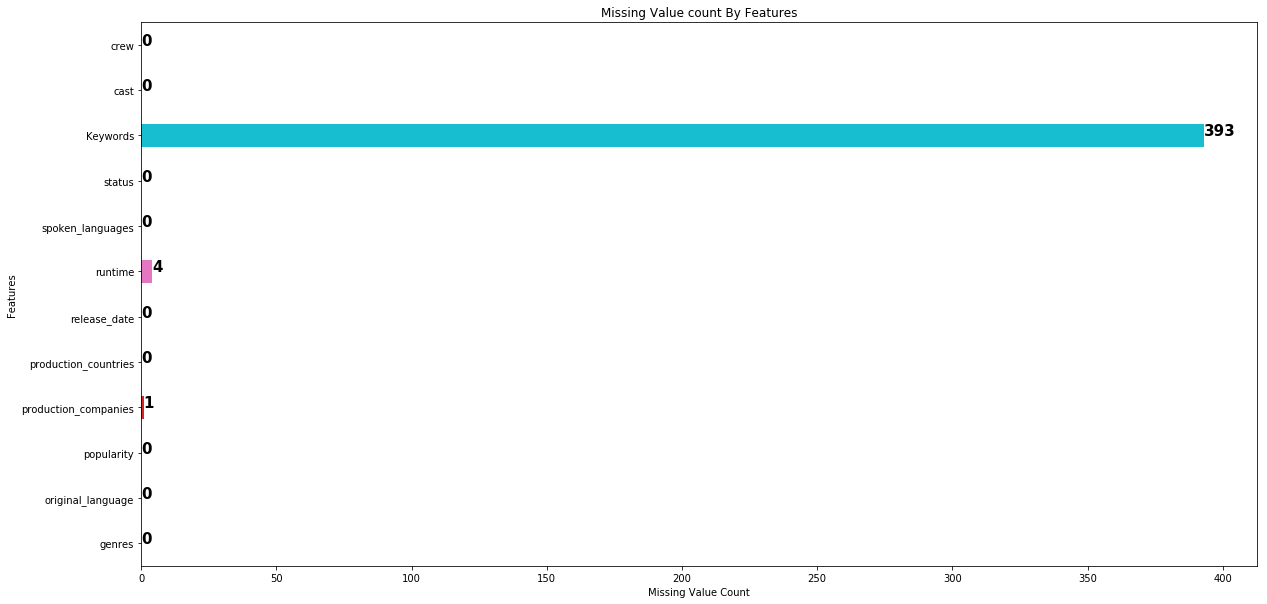

In [118]:
NullCheckGraph(df)

##### Cleaning List column

1. Genres

In [119]:
#Fetch only name from genres column

df['genres'] = df['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x,list) else [])

mlb = MultiLabelBinarizer()
df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('genres')), columns=mlb.classes_, index=df.index))

df.head(1)

,original_language,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,Keywords,cast,...,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
0,ja,3.851534,NaN,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...",...,0,0,0,0,0,0,0,0,0,0


2. Converting to list: cast, crew, production_companies, production_countries, spoken_languages column

In [120]:
"""Safely evaluate an expression node or a Unicode or Latin-1 encoded string containing a Python expression. 
The string or node provided may only consist of the following Python literal structures: strings, numbers, 
tuples, lists, dicts, booleans, and None. This can be used for safely evaluating strings containing Python expressions 
from untrusted sources without the need to parse the values oneself.

Also read issue with CSV
https://stackoverflow.com/questions/23111990/pandas-dataframe-stored-list-as-string-how-to-convert-back-to-list

https://stackoverflow.com/questions/29552950/when-to-use-ast-literal-eval"""

df['cast'] = df['cast'].apply(literal_eval)
#df['crew'] = df['crew'].apply(literal_eval)
#df['production_companies'] = df['production_companies'].apply(literal_eval)
#df['production_countries'] = df['production_countries'].apply(literal_eval)
#df['spoken_languages'] = df['spoken_languages'].apply(literal_eval)

##### Extracting feature from cast column

In [121]:
def get_director(x):
    for i in x:
        if['job'] == 'Director':
            return i['name']
    return np.nan
    
df['director'] = df['crew'].apply(get_director)

#One hot encode 
dfDummies = pd.get_dummies(df['director'], prefix = 'director')
df = pd.concat([df,dfDummies], axis=1)

df['cast'] = df['cast'].apply(lambda x : [i['name'] for i in x] if isinstance(x,list) else [])

df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('cast')), columns=mlb.classes_, index=df.index))

#mlb = MultiLabelBinarizer()
#df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('director')), columns=mlb.classes_, index=df.index))

df.head(1)

,original_language,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,Keywords,crew,...,√ìlafur Darri √ìlafsson,√ìlafur Flosason,√ìscar Casas,√ìscar Jaenada,√ìscar Sim√≥n,√íscar Foronda,√ñzcan √ñzdemir,√òyvind Hagen-Traberg,≈ûener ≈ûen,≈Ωeljko Kecojeviƒá
0,ja,3.851534,NaN,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de...",...,0,0,0,0,0,0,0,0,0,0


##### Cleaning spoken_languages

In [122]:
df['spoken_languages'] = df['spoken_languages'].apply(lambda x : [i['name'] for i in x] if isinstance(x,list) else [])

df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('spoken_languages')), columns=mlb.classes_, index=df.index))

df.head(1)

,original_language,popularity,production_companies,production_countries,release_date,runtime,status,Keywords,crew,Action,...,√ìlafur Darri √ìlafsson,√ìlafur Flosason,√ìscar Casas,√ìscar Jaenada,√ìscar Sim√≥n,√íscar Foronda,√ñzcan √ñzdemir,√òyvind Hagen-Traberg,≈ûener ≈ûen,≈Ωeljko Kecojeviƒá
0,ja,3.851534,NaN,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.0,Released,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de...",0,...,0,0,0,0,0,0,0,0,0,0


##### Cleaning production_companies

In [123]:
df['production_companies'] = df['production_companies'].apply(lambda x : [i['name'] for i in x] if isinstance(x,list) else [])

df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('production_companies')), columns=mlb.classes_, index=df.index))

df.head(1)

,original_language,popularity,production_countries,release_date,runtime,status,Keywords,crew,Action,Adventure,...,√ìlafur Darri √ìlafsson,√ìlafur Flosason,√ìscar Casas,√ìscar Jaenada,√ìscar Sim√≥n,√íscar Foronda,√ñzcan √ñzdemir,√òyvind Hagen-Traberg,≈ûener ≈ûen,≈Ωeljko Kecojeviƒá
0,ja,3.851534,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.0,Released,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de...",0,1,...,0,0,0,0,0,0,0,0,0,0


##### Cleaning production_countries

In [124]:
df['production_countries'] = df['production_countries'].apply(lambda x : [i['name'] for i in x] if isinstance(x,list) else [])

df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('production_countries')), columns=mlb.classes_, index=df.index))

df.head(1)

,original_language,popularity,release_date,runtime,status,Keywords,crew,Action,Adventure,Animation,...,√ìlafur Darri √ìlafsson,√ìlafur Flosason,√ìscar Casas,√ìscar Jaenada,√ìscar Sim√≥n,√íscar Foronda,√ñzcan √ñzdemir,√òyvind Hagen-Traberg,≈ûener ≈ûen,≈Ωeljko Kecojeviƒá
0,ja,3.851534,7/14/07,90.0,Released,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de...",0,1,1,...,0,0,0,0,0,0,0,0,0,0


##### One hot encode Original_Language 

In [125]:
df['original_language'] = np.where(df['original_language'] == 'en', 1, 0)

df.head(1)

,original_language,popularity,release_date,runtime,status,Keywords,crew,Action,Adventure,Animation,...,√ìlafur Darri √ìlafsson,√ìlafur Flosason,√ìscar Casas,√ìscar Jaenada,√ìscar Sim√≥n,√íscar Foronda,√ñzcan √ñzdemir,√òyvind Hagen-Traberg,≈ûener ≈ûen,≈Ωeljko Kecojeviƒá
0,0,3.851534,7/14/07,90.0,Released,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de...",0,1,1,...,0,0,0,0,0,0,0,0,0,0


##### One hot encode Status

In [126]:
dfDummies = pd.get_dummies(df['status'], prefix = 'status')

df = pd.concat([df,dfDummies], axis=1)

df.head(1)

,original_language,popularity,release_date,runtime,status,Keywords,crew,Action,Adventure,Animation,...,√ìscar Jaenada,√ìscar Sim√≥n,√íscar Foronda,√ñzcan √ñzdemir,√òyvind Hagen-Traberg,≈ûener ≈ûen,≈Ωeljko Kecojeviƒá,status_Post Production,status_Released,status_Rumored
0,0,3.851534,7/14/07,90.0,Released,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de...",0,1,1,...,0,0,0,0,0,0,0,0,1,0


##### Get year from Date and One hot encode it

In [127]:
#df['release_date'].head(5)

In [128]:
df['release_date'] = pd.to_datetime(df['release_date'])
#df['release_date'].head(5)

In [129]:
df['year'] = df['release_date'].dt.year

#dfDummies = pd.get_dummies(df['year'], prefix = 'release_year')

#df = pd.concat([df,dfDummies], axis=1)

df['year'].head(5)
#min(df['year'])
#max(df['year'])

0    2007
1    2058
2    1997
3    2010
4    2005
Name: year, dtype: int64

##### Drop column after One-Hot encoding 
##### TODO: work on Keywords, crew

In [130]:
df = df.drop(['status', 'Keywords', 'crew', 'release_date', 'director'], axis=1)

#### Check for NULL values

In [131]:
df.columns[df.isna().any()].tolist()

['runtime']

In [132]:
df['runtime'].fillna(method='ffill', inplace=True)

In [133]:
df.columns[df.isna().any()].tolist()

[]

In [134]:
df.columns

Index(['original_language', 'popularity', 'runtime', 'Action', 'Adventure',
       'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama',
       ...
       '√ìscar Sim√≥n', '√íscar Foronda', '√ñzcan √ñzdemir',
       '√òyvind Hagen-Traberg', '≈ûener ≈ûen', '≈Ωeljko Kecojeviƒá',
       'status_Post Production', 'status_Released', 'status_Rumored', 'year'],
      dtype='object', length=53201)

In [135]:
X = df
X.columns

Index(['original_language', 'popularity', 'runtime', 'Action', 'Adventure',
       'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama',
       ...
       '√ìscar Sim√≥n', '√íscar Foronda', '√ñzcan √ñzdemir',
       '√òyvind Hagen-Traberg', '≈ûener ≈ûen', '≈Ωeljko Kecojeviƒá',
       'status_Post Production', 'status_Released', 'status_Rumored', 'year'],
      dtype='object', length=53201)

### Prepare the model

#### 1. Linear Model

In [136]:
from sklearn.externals import joblib
lr_model = joblib.load('LinearRegression_model.pkl')

y_pred = lr_model.predict(X)

sub_lr = pd.read_csv('sample_submission.csv')
sub_lr['revenue'] = y_pred
sub_lr.to_csv('LinearRegression_Submission.csv', index=False)

ValueError: shapes (4398,53201) and (36336,) not aligned: 53201 (dim 1) != 36336 (dim 0)

#### 2. RandomForestRegressor

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = joblib.load('RandomForestRegressor_model.pkl')

y_pred = rf_model.predict(X)

sub_lr = pd.read_csv('sample_submission.csv')
sub_lr['revenue'] = y_pred
sub_lr.to_csv('RandomForestRegressor_Submission.csv', index=False)

#### 3. KNeighborsRegressor

The target is predicted by local interpolation of the targets associated of the nearest neighbors in the training set.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

kn_model = joblib.load('KNeighborsRegressor_model.pkl')

y_kn_prediction = kn_model.predict(X)

sub_lr = pd.read_csv('sample_submission.csv')
sub_lr['revenue'] = y_kn_prediction
sub_lr.to_csv('KNeighborsRegressor_Submission.csv', index=False)

#### 4. XGBRegressor

In [ ]:
"""from xgboost import XGBRegressor

xg_regressor_model = joblib.load('XGBRegressor_model.pkl')

y_pred = xg_regressor_model.predict(X_val)

y_xg_regressor_prediction = xg_regressor_model.predict(test)

sub_lr['revenue'] = y_xg_regressor_prediction
sub_lr.to_csv('XGBRegressor_Submission.csv', index=False)"""

#### "End Of Project" Check the directory, all the o/p files will be present there. We can upload the best one in the competition